# Stock price forecasting

# Modeling Random Forests and LSTM neural network

The purpose of this section is to train two machine learning models -Random Forests and LSTM neural network- to predict the `Close` price of our test dataset, and assess their performance. In both cases we will investigate how the size of the test set affects the model's performance. 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Random Forest

First step is to import the Random Forest Regressor model:

In [7]:
# Import the RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor

We need to load the training and test features and target datasets we saved in the previous notebook. We are using the unscaled datasets as Random Forests are insensitive to scaling.

In [8]:
# Load the X_train, y_train, X_test and y_test datasets

X_train = pd.read_csv('X_train_KO.csv', parse_dates=True, index_col=0)
y_train = pd.read_csv('y_train_KO.csv', parse_dates=True, index_col=0)

X_test = pd.read_csv('X_test_KO.csv', parse_dates=True, index_col=0)
y_test = pd.read_csv('y_test_KO.csv', parse_dates=True, index_col=0)

In [9]:
X_train

,Open,High,Low,Adj Close,Volume,Reported EPS,Price Change,RSI,K,EMA12,EMA26,MACD Line,Signal Line,MACD Histogram,ROC,OBV,P/E,Day,Month,Year
Date,,,,,,,,,,,,,,,,,,,,
1996-05-06,19.937500,20.218750,19.750000,10.236874,7170400,0.14,0.281250,54.166667,70.000000,20.167723,20.122550,0.045173,0.045976,-0.000803,-0.154321,-10631600,144.419643,6,5,1996
1996-05-07,20.218750,20.406250,20.156250,10.300159,6702800,0.14,0.125000,56.578947,83.333333,20.194804,20.138935,0.055869,0.047955,0.007914,1.244168,-3928800,145.312500,7,5,1996
1996-05-08,20.343750,20.687500,20.062500,10.474213,8292800,0.14,0.343750,65.853659,100.000000,20.270603,20.179569,0.091034,0.056571,0.034463,1.846154,4364000,147.767857,8,5,1996
1996-05-09,20.687500,20.937500,20.593750,10.474213,4820400,0.14,0.000000,71.052632,78.947368,20.334741,20.217194,0.117547,0.068766,0.048781,1.846154,4364000,147.767857,9,5,1996
1996-05-10,20.718750,20.968750,20.718750,10.616608,4942800,0.14,0.281250,68.571429,100.000000,20.432281,20.272865,0.159416,0.086896,0.072520,3.389831,9306800,149.776786,10,5,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,60.750000,62.290001,60.669998,59.126160,23064200,0.64,-0.070000,39.502762,18.965543,62.600185,63.125886,-0.525701,-0.299640,-0.226061,-3.218682,2802664700,95.843750,13,6,2022
2022-06-14,60.730000,60.889999,58.660000,57.504799,24620000,0.64,-2.110001,20.757061,8.850929,62.081695,62.837302,-0.755607,-0.390833,-0.364773,-6.088473,2778044700,92.546874,14,6,2022
2022-06-15,60.000000,60.639999,58.970001,57.931984,19684700,0.64,0.439999,24.358971,15.683207,61.710665,62.602687,-0.892022,-0.491071,-0.400951,-6.370628,2797729400,93.234372,15,6,2022


We now proceed to train our Random Forest model and make predictions on the testing dataset. We choose to use a Random Forest Regressor model with 100 trees (n_estimators=100) and set a random seed for reproducibility of our results (random_state=42).

In [10]:
# Initialize the random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the testing data
y_pred = rf_model.predict(X_test)


The performance of the model will be assessed by using the mean squared error (MSE):

In [11]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.4868624290997525


In order to compare the predicted values of the target variable and its actual values we plot the corresponding series:

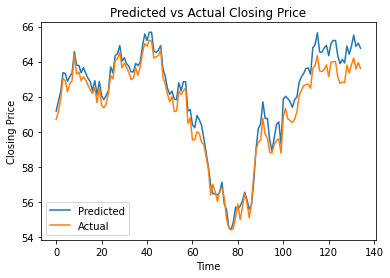

In [12]:
# Create a range of indices for the x-axis
x = range(len(y_pred))

# Plot the predicted values (y_pred) and the true values (y_test)
plt.plot(x, y_pred, label='Predicted')
plt.plot(x, y_test, label='Actual')

# Set y-axis label
plt.ylabel('Closing Price')

# Set x-axis label
plt.xlabel('Time')

# Set plot title
plt.title('Predicted vs Actual Closing Price')

# Add legend
plt.legend()

# Show the plot
plt.show()

We observe a quite good match between the predicted and actual Closing price distributions. Although the curves tend to slightly spread out from each other past around 90 timesteps, their shapes remain practically identical.

## Long-Short-Term-Memory neural network

LSTM networks are a type of Recurrent Neural Network (RNN) that are designed to remember patterns over time. They are particularly good at recognizing patterns over periods of time which makes them very useful for time-series data.

In [13]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Load data into DataFrame 
df = pd.read_csv('KO.csv')

# Compute the number of data points for 80% of the data
train_size = int(0.8 * len(df))

# Split into train and test sets
train = df[['Close']][:train_size]
test = df[['Close']][train_size:]

# Scale the features and target together
scaler = MinMaxScaler(feature_range=(0,1))

# Fit the scaler using only the training data and transform
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=['Close'])

# Scale the test data
test_scaled = pd.DataFrame(scaler.transform(test), columns=['Close'])

In order to train our LSTM network, we need a further processing of our data that will render it into a suitable format that can be fed to the network. In time series forecasting with LSTM, it is common to use a certain number of previous steps to predict the next step. This is often referred to as a 'sliding window' approach. 


We will define a function `create_dataset` that creates this sliding window, taking a time series dataset and a parameter `look_back` as inputs. The `look_back` parameter is the number of previous time steps to use as input variables to predict the next time period.   The function will return two outputs:  a 2D numpy array `X` where each row corresponds to a sequence of `look_back` number of previous values from the dataset, and a 1D numpy array `Y` where each value corresponds to the next value in the dataset that follows the sequence in `X`. `X` contains the input features for our LSTM model, whereas `Y` is the target variable that our LSTM model will aim to predict.

In [14]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+seq_length]  # removed .values
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Specify the sequence length
seq_length = 60

# Create sequences from train and test data
X_train, y_train = create_sequences(train_scaled['Close'], seq_length)
X_test, y_test = create_sequences(test_scaled['Close'], seq_length)


In [15]:
# Reshape the inputs to be suitable for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

2023-07-30 13:06:23.976227: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 13:06:24.422817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-30 13:06:24.425633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 13:06:26.819832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:

# Initialize a sequential model
model = Sequential()

# Add the first LSTM layer with 50 units, input shape, and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a second LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True))
# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a third LSTM layer with 50 units
model.add(LSTM(units=50))
# Add dropout to prevent overfitting
model.add(Dropout(0.2))

# Add a dense output layer with one unit
model.add(Dense(units=1))

2023-07-30 13:06:32.088247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 13:06:32.092437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 13:06:32.095188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [18]:
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    X_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25


2023-07-30 13:06:41.838499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 13:06:41.842536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 13:06:41.846410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

167/167 [==============================] - 33s 111ms/step - loss: 0.0126
Epoch 2/25
167/167 [==============================] - 19s 111ms/step - loss: 0.0036
Epoch 3/25
167/167 [==============================] - 18s 108ms/step - loss: 0.0033
Epoch 4/25
167/167 [==============================] - 19s 114ms/step - loss: 0.0028
Epoch 5/25
167/167 [==============================] - 18s 109ms/step - loss: 0.0028
Epoch 6/25
167/167 [==============================] - 20s 120ms/step - loss: 0.0026
Epoch 7/25
167/167 [==============================] - 18s 110ms/step - loss: 0.0024
Epoch 8/25
167/167 [==============================] - 19s 113ms/step - loss: 0.0022
Epoch 9/25
167/167 [==============================] - 19s 116ms/step - loss: 0.0021
Epoch 10/25
167/167 [==============================] - 18s 110ms/step - loss: 0.0019
Epoch 11/25
167/167 [==============================] - 19s 113ms/step - loss: 0.0017
Epoch 12/25
167/167 [==============================] - 17s 103ms/step - loss: 0.0017


In [20]:
test_predict = model.predict(X_test)

2023-07-30 13:15:27.280980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-30 13:15:27.284909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-30 13:15:27.287833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

41/41 [==============================] - 4s 38ms/step


In [21]:
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

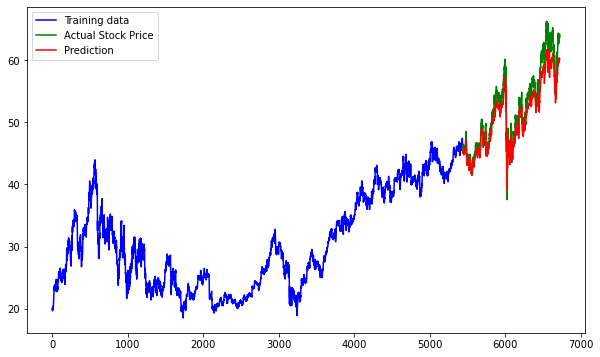

In [22]:
plt.figure(figsize=(10,6))
plt.plot(df.index[:len(train)+seq_length], df['Close'][:len(train)+seq_length], color='blue', label='Training data')
plt.plot(df.index[len(train)+seq_length:-1], df['Close'][len(train)+seq_length:-1], color='green', label='Actual Stock Price')
plt.plot(df.index[len(train)+seq_length:-1], test_predict, color='red', label='Prediction')
plt.legend()
plt.show()

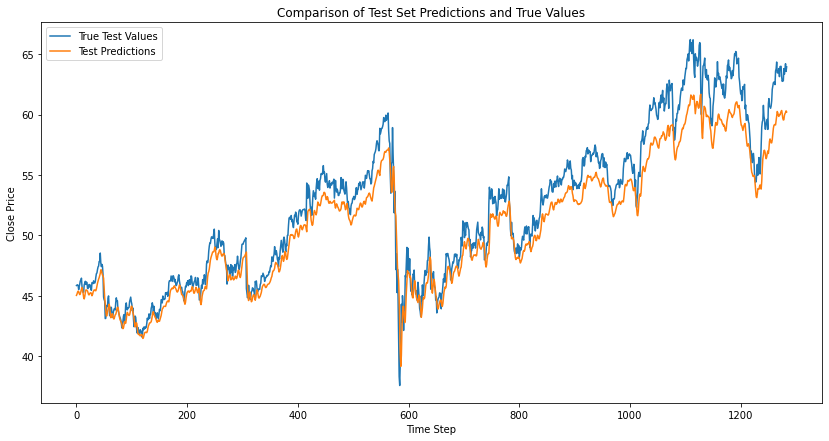

In [23]:
# plot test predictions and actual values
plt.figure(figsize=(14,7))
plt.plot(y_test[0], label='True Test Values')
plt.plot(test_predict, label='Test Predictions')
plt.title('Comparison of Test Set Predictions and True Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test[0], test_predict)
print(mse)

3.8293048065574653
